In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torcheval.metrics.functional import bleu_score

In [4]:
%load_ext autoreload
%autoreload 2

In [46]:
import sys
sys.path.append('/content/drive/MyDrive/d2l.ai_implementation/chapter11')
from MTFraEng import MTFraEng
from AttentionEncoderDecoder import AttentionEncoderDecoder
from Training import train

In [6]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/fra-eng/fra.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [9]:
num_train, num_val = 4096, 512
batch_size=128
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
learning_rate=0.005
num_epochs=30

In [10]:
train_data = MTFraEng(PATH, train=True, num_train=num_train, num_val=num_val)
test_data = MTFraEng(PATH, train=False, num_train=num_train, num_val=num_val)

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

In [47]:
model = AttentionEncoderDecoder(
    len(train_data.src_vocab),
    len(train_data.tgt_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
).to(DEVICE)

In [48]:
def loss(pred, label, tgt_pad, criterion):
    mask = (label != tgt_pad)
    loss = criterion(pred, label)
    return (loss * mask).sum() / mask.sum()

In [49]:
epochs = 50
criterion = nn.CrossEntropyLoss(reduction='none')
loss_fn = lambda pred, label: loss(pred, label, train_data.tgt_vocab['<pad>'], criterion)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
train_losses, test_losses = train(
    model,
    DEVICE,
    train_loader,
    test_loader,
    optimizer,
    loss_fn,
    epochs
)

Epoch [1/50]
Train Loss = 4.75652384757995605469
Test Loss = 4.30593323707580566406

Epoch [2/50]
Train Loss = 3.34263464063405990601
Test Loss = 3.79774731397628784180

Epoch [3/50]
Train Loss = 2.71369735151529312134
Test Loss = 3.46784240007400512695

Epoch [4/50]
Train Loss = 2.26549531519412994385
Test Loss = 3.29821187257766723633

Epoch [5/50]
Train Loss = 1.91046203672885894775
Test Loss = 3.23645329475402832031

Epoch [6/50]
Train Loss = 1.62745068967342376709
Test Loss = 3.24865585565567016602

Epoch [7/50]
Train Loss = 1.38960266485810279846
Test Loss = 3.25297516584396362305

Epoch [8/50]
Train Loss = 1.19017716497182846069
Test Loss = 3.28973609209060668945

Epoch [9/50]
Train Loss = 1.03809851966798305511
Test Loss = 3.31427347660064697266

Epoch [10/50]
Train Loss = 0.92022974602878093719
Test Loss = 3.29232114553451538086

Epoch [11/50]
Train Loss = 0.80245770700275897980
Test Loss = 3.33060663938522338867

Epoch [12/50]
Train Loss = 0.72280958481132984161
Test Loss = 3

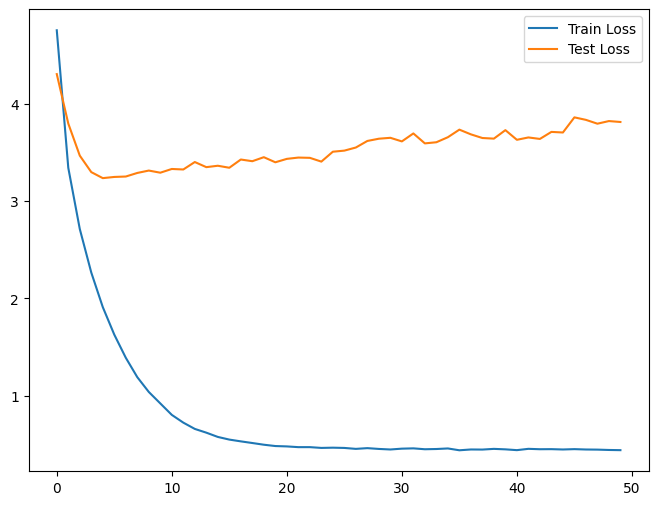

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.show()

In [52]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
arrays= train_data.build(engs, fras)
src, tgt, src_valid_len, label = arrays

In [53]:
pred = model.predict(src, src_valid_len, train_data.tgt_vocab, 9, DEVICE)

In [54]:
for en, fr, p in zip(engs, fras, pred):
    translation = []
    for token in p:
        word = train_data.tgt_vocab.lookup_token(token)
        if word == '<eos>':
            break
        translation.append(word)

    print(f'{en} => {translation}, bleu: {bleu_score(" ".join(translation), [fr], n_gram=2)}')

go . => ['en', 'route', '!'], bleu: 0.0
i lost . => ["j'ai", 'perdu', '.'], bleu: 1.0
he's calm . => ['il', 'va', 'peut-être', 'ça', '.'], bleu: 0.0
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu: 1.0
